# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Output-Joe-Gray-Breast-Cancer-drug-screening-curves" data-toc-modified-id="Output-Joe-Gray-Breast-Cancer-drug-screening-curves-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Output Joe Gray Breast Cancer drug screening curves</a></div>

# Output Joe Gray Breast Cancer drug screening curves

The process in this notebook is fairly simple, as the data is organized into rows of the table and therefore all that needs to be done is to take summaries of background and control measurements, and replicate the concentration for each technical replicate. 


Set Paramaters

In [ ]:
install.packages('matrixStats')

In [ ]:
require(matrixStats)||install.packages('matrixStats')

In [ ]:
options(stringsAsFactors=FALSE)
library(data.table)

concentrations.no <- 9
replicate.no <- 3

nCurvesReturned <- "all" # This parameter will determine how many curves to sample and return (numeric), 
                         # or return all curves

Read in data currently from the github repository itself, since download needs to be done through Synapse with login otherwise. 

In [ ]:
gray.raw.drug.sensitivity <- fread(file="./GRAYdata/Gray_data_raw_dose_response.csv")
gray.conc <- fread("./GRAYdata/Gray_drug_conc.csv")

gray.raw.drug.sensitivity[,
      background := rowMedians(data.matrix(gray.raw.drug.sensitivity[,grep("^background_od", 
                                                                           colnames(gray.raw.drug.sensitivity),
                                                                            v=TRUE), with=FALSE]))]

gray.raw.drug.sensitivity[,
      ctrl := rowMedians(data.matrix(gray.raw.drug.sensitivity[,grep("^od0\\.", 
                                                                      colnames(gray.raw.drug.sensitivity),
                                                                       v=TRUE), with=FALSE])) - background]


for( i in seq_len(concentrations.no)){
    for(j in seq_len(replicate.no)){
        curCol <- paste0("response", i, "." ,j)
        gray.raw.drug.sensitivity[,
          (curCol) := (rowMedians(data.matrix(gray.raw.drug.sensitivity[,paste0("od", i, ".", j), 
                                                                        with=FALSE])) - background)/ctrl * 100]
    }
}

In [4]:
gray.raw.drug.sensitivity.bk <- gray.raw.drug.sensitivity
summary(gray.raw.drug.sensitivity.bk[,grep("^background_od", 
                                                                           colnames(gray.raw.drug.sensitivity.bk),
                                                                            v=TRUE), with=FALSE])
which.max(gray.raw.drug.sensitivity.bk[,grep("^background_od", 
                                                                           colnames(gray.raw.drug.sensitivity.bk),
                                                                            v=TRUE), with=FALSE][[1]])
which.max(gray.raw.drug.sensitivity.bk[,grep("^response", 
                                                                           colnames(gray.raw.drug.sensitivity.bk),
                                                                            v=TRUE), with=FALSE][[1]])
gray.raw.drug.sensitivity.bk[295,grep("^response", 
                                                                           colnames(gray.raw.drug.sensitivity.bk),
                                                                            v=TRUE), with=FALSE]
print(gray.raw.drug.sensitivity.bk[295])

 background_od1    background_od2  
 Min.   :  11.00   Min.   :  13.0  
 1st Qu.:  63.00   1st Qu.: 117.0  
 Median :  79.00   Median : 138.0  
 Mean   :  88.59   Mean   : 147.3  
 3rd Qu.:  97.00   3rd Qu.: 160.0  
 Max.   :7131.00   Max.   :7325.0  

[1] 3022

[1] 295

response1.1,response1.2,response1.3,response2.1,response2.2,response2.3,response3.1,response3.2,response3.3,response4.1,⋯,response6.3,response7.1,response7.2,response7.3,response8.1,response8.2,response8.3,response9.1,response9.2,response9.3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10510,127.1429,171.4286,80,-48.57143,10787.14,0,8265.714,10471.43,-35.71429,⋯,-81.42857,-102.8571,-92.85714,42.85714,-17.14286,-88.57143,-108.5714,-120,-104.2857,-115.7143


    ID  cellline tissue          drug security drug_plate_id T0_plate_id
1: 713 MDAMB468D breast Bromopyruvate   public         13044       13046
   drug_group_id background_od1 background_od2 od0.1 od0.2 od0.3 od1.1 od1.2
1:           177             71            123    73   167  2674  7454   186
   od1.3 od2.1 od2.2 od2.3 od3.1 od3.2 od3.3 od4.1 od4.2 od4.3 od5.1 od5.2
1:   217   153    63  7648    97  5883  7427    72  8006  7331    35   158
   od5.3 od6.1 od6.2 od6.3 od7.1 od7.2 od7.3 od8.1 od8.2 od8.3 od9.1 od9.2
1:  3531   190   115    40    25    32   127    85    35    21    13    24
   od9.3 T0_background_od1 T0_background_od2 T0_median_od background ctrl
1:    16                55               132       2706.5         97   70
   response1.1 response1.2 response1.3 response2.1 response2.2 response2.3
1:       10510    127.1429    171.4286          80   -48.57143    10787.14
   response3.1 response3.2 response3.3 response4.1 response4.2 response4.3
1:           0    8265.714 

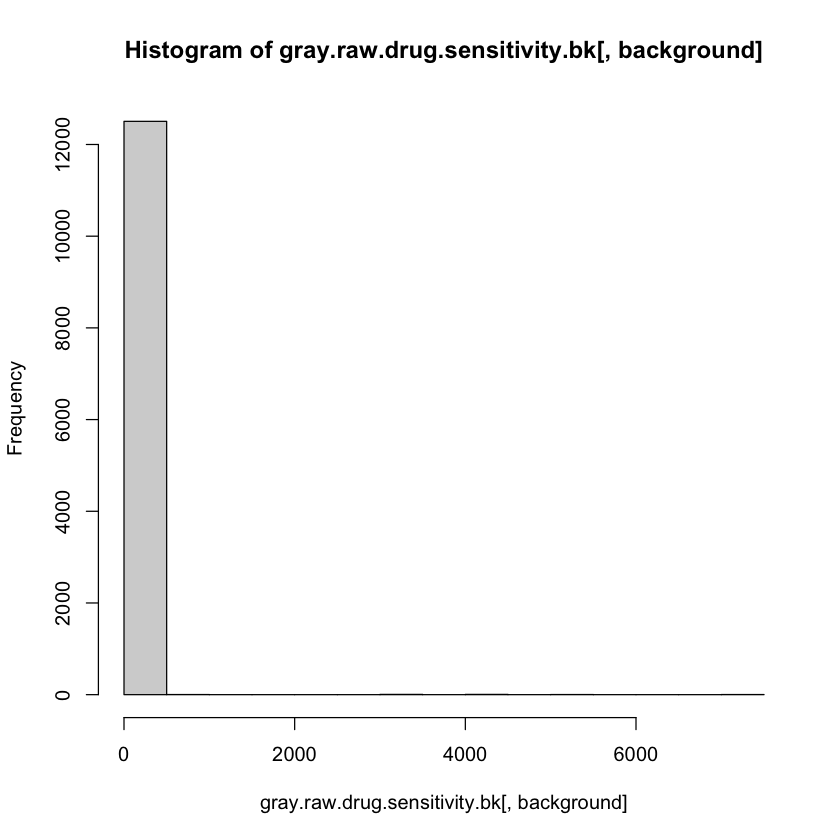

In [5]:
hist(gray.raw.drug.sensitivity.bk[,background])

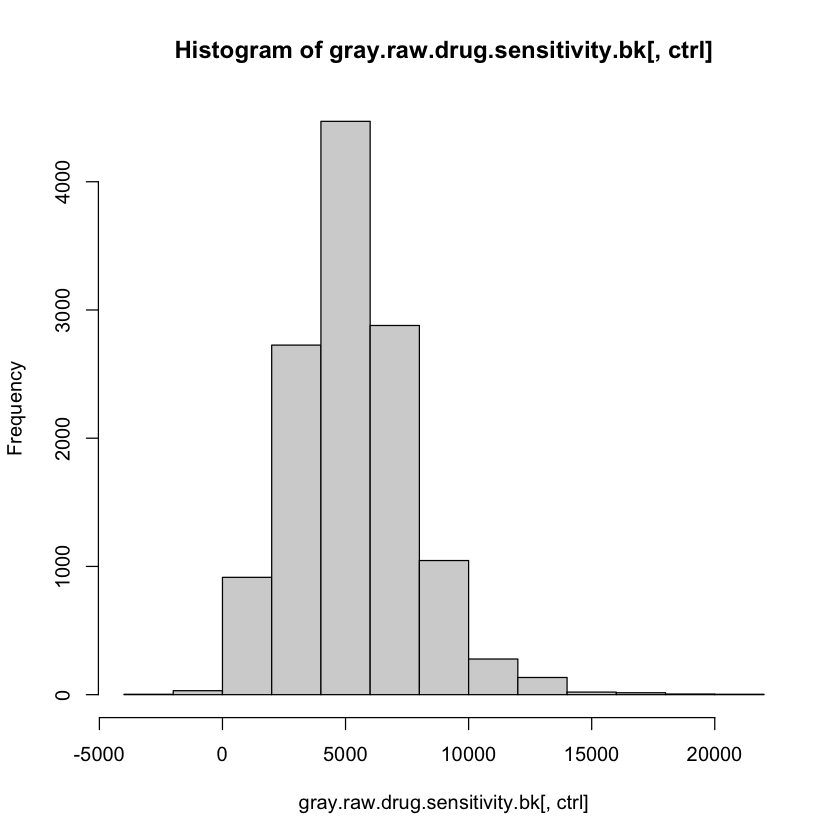

In [6]:
hist(gray.raw.drug.sensitivity.bk[,ctrl])

In [7]:
gray.raw.drug.sensitivity <- gray.raw.drug.sensitivity[,-grep("^od", 
                                                              colnames(gray.raw.drug.sensitivity), 
                                                              v=TRUE), with=FALSE]

gray.raw.drug.sensitivity <- gray.raw.drug.sensitivity[,-grep("*background*", 
                                                              colnames(gray.raw.drug.sensitivity), 
                                                              v=TRUE), with=FALSE]
gray.raw.drug.sensitivity <- gray.raw.drug.sensitivity[,-c("T0_median_od")]



gray.raw.drug.sensitivity <- merge(x=gray.raw.drug.sensitivity, 
                                   y=gray.conc, by=c("drug_group_id", "drug"), all.x=TRUE)



gray.raw.drug.sensitivity[,exp_id := paste(drug, cellline, ID.x, sep="_")]

conc.cols <- grep("^c[0-9]+", colnames(gray.raw.drug.sensitivity), v=TRUE)

gray.raw.drug.sensitivity[,(conc.cols) := lapply(.SD, function(x) return(x*1e6)), .SDcols = conc.cols]
gray.raw.drug.sensitivity <- gray.raw.drug.sensitivity[units=="M"] # removing one drug in mg/ml for now. 


                                                 
gray.conc.m <- data.table::melt(gray.raw.drug.sensitivity[,c("exp_id", conc.cols), with=FALSE], id.vars="exp_id")                                                 
                                                 
colnames(gray.conc.m) <- c("exp_id", "DoseNum", "DoseValue") 

gray.conc.m[,DoseNum := gsub(DoseNum, pat="c", rep="")]
   
response.cols <- grep("response", x=colnames(gray.raw.drug.sensitivity), v=TRUE)


gray.raw.m <- data.table::melt(gray.raw.drug.sensitivity[,c("exp_id", response.cols), with=FALSE], id.vars="exp_id")
       
colnames(gray.raw.m) <- c("exp_id", "DoseNum", "Response")
gray.raw.m[,DoseNum := gsub(DoseNum, pat="^response|\\.[0-9]$", rep="")]

gray.raw.drug.sensitivity.m <- merge(gray.conc.m, gray.raw.m, by=c("exp_id", "DoseNum"))

gray.raw.drug.sensitivity.m[,DoseNum:=NULL]
                                                 
colnames(gray.raw.drug.sensitivity.m) <- c("exp_id", "Concentration", "Viability")

sensitivity.info <- gray.raw.drug.sensitivity[,.(exp_id, drug, cellline)]

## Note the data.table syntax here, differs from base R
min.doses <-  gray.raw.drug.sensitivity.m[,.(min_dose = min(Concentration)), exp_id]
max.doses <-  gray.raw.drug.sensitivity.m[,.(max_dose = max(Concentration)), exp_id]

sensitivity.info <- sensitivity.info[min.doses, on="exp_id"][max.doses, on="exp_id"]
sensitivity.info$nbr.conc.tested <- 9

colnames(sensitivity.info)[2:3] <- c("drugid", "cellid")
head(sensitivity.info)
sensitivity.info <- data.frame(sensitivity.info)
                                                 
cells.cross.reference <- read.csv("./GRAYdata/DS0_crossreferencingCELLS.txt", header=T, stringsAsFactors=FALSE, sep="\t")
drugs.cross.reference <- read.csv("./GRAYdata/DS0_crossreferencingPERTURBAGENS.txt", header=T, stringsAsFactors=FALSE, sep="\t")
    
remove.items <- which(sensitivity.info[,"cellid"] %in% cells.cross.reference[which(cells.cross.reference$COMMENT == "REMOVE"), "HEISER.NAME"])
sensitivity.info <- sensitivity.info[-remove.items,]
                                                 
remove.items.dd <- which(sensitivity.info[,"drugid"] %in% drugs.cross.reference[which(drugs.cross.reference$COMMENT == "REMOVE"), "HEISER.NAME"])
sensitivity.info <- sensitivity.info[-remove.items.dd,]

gray.raw.drug.sensitivity.m <- gray.raw.drug.sensitivity.m[exp_id %in% sensitivity.info$exp_id]

                                                 

[1] 13028 12687 12693 13108 13044 12998 13116 13003 13052  7725  7726  7763
 [13]  7767 14123 14126 14127 14144 14145 14153 14178 14201 14213 14288 14319
 [25] 14321 14333 14790 10244 10117  9789  8332  8401  8496  8522  9778  8086
 [37]  8040  8126  8133  8197  8199  8334  8417  8538  8726  8331  8458  8536
 [49]  8686  9775  9795  9780 10241 10116  7765  6600  6560  6767  6602  7315
 [61]  6603  6608  6321  6606  7322  7327  6609  6735  6757  6591 10138  9779
 [73]  9801 12342 12341 12091 11131 11452 12094 12349 11454 12344 12347 12085
 [85] 12089 12343 12532 12345 12352  8337  8516  9785 10245  7628  7724  6558
 [97]  6607 12093 10247  9783 10058  6940 11658  6601  6582  7325 12350  8329
[109]  9784  9786

[1] 0.0134121

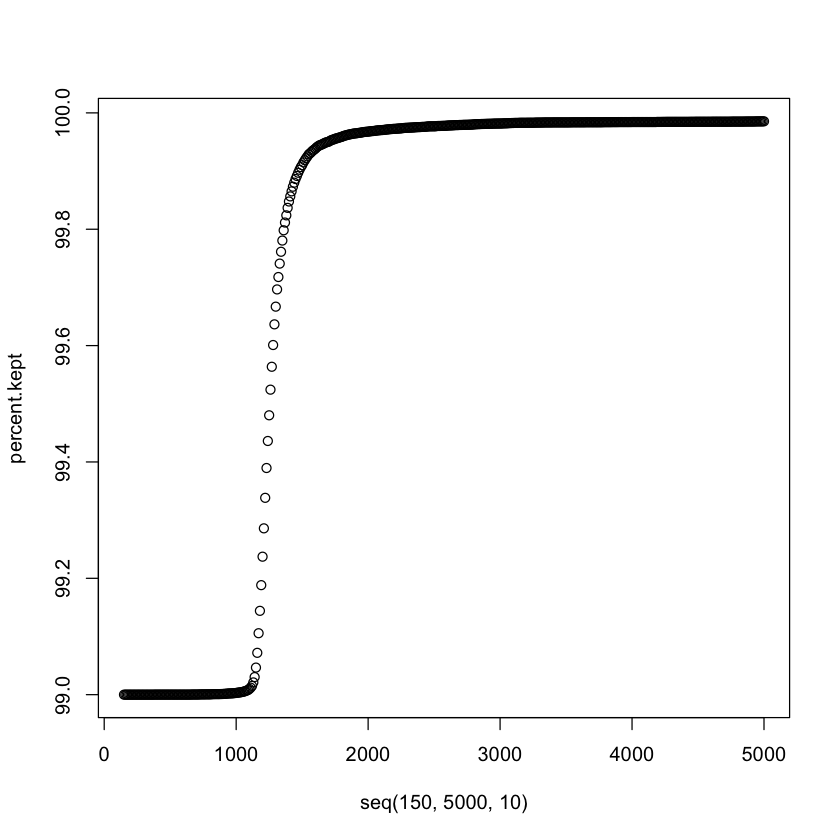

In [8]:
# gray.raw.drug.sensitivity.m[exp_id == "5-FU_MDAMB157_5119",]
# print(gray.raw.drug.sensitivity.bk[cellline == "MDAMB157" & drug == "5-FU"][2])
resp_data <- data.matrix(gray.raw.drug.sensitivity.bk[,grep("^response", 
                                                                           colnames(gray.raw.drug.sensitivity.bk),
                                                                            v=TRUE), with=FALSE])


myx <- apply(resp_data < -5 | resp_data > 300, 1, any)
gray.raw.drug.sensitivity.bk[myx, unique(drug_plate_id)]

percent.kept <- numeric(length(seq(200,10000, 100)))

j<-1
for(i in seq(150,5000, 10)){
    myx <- apply(resp_data < -5 | resp_data > j, 1, any)
    
    percent.kept[j] <- 100-length(gray.raw.drug.sensitivity.bk[myx,drug_plate_id])/length(gray.raw.drug.sensitivity.bk[,drug_plate_id])
    j <- j + 1 
}
plot(seq(150,5000, 10),percent.kept) ## From this plot, it looks like 1000 might be a good place to put this threshold


myx <- apply(resp_data < -5 | resp_data > 1000, 1, any)

length(gray.raw.drug.sensitivity.bk[myx,drug_plate_id])/length(gray.raw.drug.sensitivity.bk[,drug_plate_id])



Now we will again download if necessary the curation files and remap the cell line and drug names, as in the other files.

In [ ]:
## Defining a function used below


matchToIDTable <- function(ids,tbl, column, returnColumn="unique.cellid") {
  sapply(ids, function(x) {
                          myx <- grep(paste0("((///)|^)",Hmisc::escapeRegex(trimws(x)),"((///)|$)"), tbl[,column])
                          if(length(myx) > 1){
                            stop("Something went wrong in curating ids, we have multiple matches")
                          }
        if(length(myx) == 0){return(NA_character_)}
                          return(tbl[myx, returnColumn])
                        })
}

In [ ]:
cellAnnotFile <- "./cellAnnotations/cell_annotation_all.csv"

if(!file.exists(cellAnnotFile)){
    dir.create("./cellAnnotations")
    cellUrl <- "https://github.com/BHKLAB-Pachyderm/Annotations/raw/master/cell_annotation_all.csv"
    download.file(cellUrl, destfile = cellAnnotFile)
}

In [ ]:
drugAnnotFile <- "./drugAnnotations/drugs_with_ids.csv"

if(!file.exists(drugAnnotFile)){
    dir.create("./drugAnnotations")
    drugUrl <- "https://github.com/BHKLAB-Pachyderm/Annotations/raw/master/drugs_with_ids.csv"
    download.file(drugUrl, destfile = drugAnnotFile)
}

In [ ]:
curationCell <- read.csv(cellAnnotFile)
curationDrug <- read.csv(drugAnnotFile)
head(sensitivity.info)

In [ ]:
sensitivity.info[, "cellid"] <- cells.cross.reference$LINCS.NAME[match( sensitivity.info[, "cellid"], cells.cross.reference[ , "HEISER.NAME"])]


sensitivity.info[, "cellid"] <- gsub("-", "", sensitivity.info[, "cellid"])
sensitivity.info[, "cellid"] <- gsub(" ", "", sensitivity.info[, "cellid"])
sensitivity.info[, "cellid"] <- toupper(sensitivity.info[, "cellid"])
    
sensitivity.info[, "drugid"] <- gsub("\\s*\\([^\\)]+\\)","",sensitivity.info[, "drugid"])
   


message("mapping sensitivity cells")

mapInfo <- data.frame(GRAY.cellid = unique(sensitivity.info[["cellid"]]), 
                      unique.cellid = matchToIDTable(unique(sensitivity.info[["cellid"]]), curationCell, "GRAY.cellid", "unique.cellid"))
stopifnot(!anyNA(mapInfo[,2]))
sensitivity.info[, "cellid"] <- mapInfo[match(sensitivity.info[, "cellid"], mapInfo[,1]),2]


message("mapping sensitivity drugs")

mapInfo <- data.frame(GRAY.drugid = unique(sensitivity.info$drugid), 
                      unique.drugid = matchToIDTable(unique(sensitivity.info$drugid), curationDrug, "GRAY.drugid", "unique.drugid"))
stopifnot(!anyNA(mapInfo[,2]))
sensitivity.info[, "drugid"] <- mapInfo[match(sensitivity.info[, "drugid"], mapInfo[,1]),2]



In [ ]:
sensitivity.info

In [ ]:
gray.raw.drug.sensitivity.m[, length(unique(exp_id))]

[1] 9750

In [ ]:
                             
if(nCurvesReturned != "all"){
    sample_expid <- sample(gray.raw.drug.sensitivity.m[, unique(exp_id)], nCurvesReturned)
    gray_raw_selected <- gray.raw.drug.sensitivity.m[exp_id %in% sample_expid]
} else {gray_raw_selected <- gray.raw.drug.sensitivity.m}  
                                                 
                                                 
                     
if(!file.exists("curves")) dir.create("curves")                         

fwrite(gray_raw_selected, file=paste0("curves/gray_selected_curves_", nCurvesReturned, ".csv"))


                            

In [ ]:
if(!file.exists("curves_info")) dir.create("curves_info")                         

fwrite(sensitivity.info, file=paste0("curves_info/GRAY_info.csv"))